# 用于验证回测框架的独立程序

**目的**: 使用带教老师提供的已包含交易信号的数据，运行现有的回测与评估框架，
以便与基准结果进行对比，验证框架的正确性。

**核心逻辑**:
1.  加载带教老师提供的pickle数据 (`_test_backtest_intern.pkl`)。
2.  直接使用数据中的 `signal` 和 `close` 列。
3.  调用 `run_vectorized_backtest` 函数进行向量化回测。
4.  调用 `evaluate_performance` 函数计算并展示详细性能指标。
5.  此脚本不涉及任何模型训练，因为交易信号已给定。

In [6]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [7]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数 (源于您的代码)

In [8]:
def run_vectorized_backtest(prices, signals, initial_capital=100000, commission_rate=0.0005, long_threshold=0.001, short_threshold=-0.001):
    """
    执行向量化回测。

    参数:
    - prices (pd.Series): 'close'价格序列，用于计算收益和净值。
    - signals (pd.Series): 模型的原始预测值或离散信号序列。
    - initial_capital (float): 初始资金。
    - commission_rate (float): 交易手续费率。
    - long_threshold (float): 做多阈值。
    - short_threshold (float): 做空阈值。

    返回:
    - pd.DataFrame: 包含净值曲线、收益、持仓和交易详情的结果。
    """
    logging.info("🤔🤔开始执行向量化回测...")
    
    # --- 1. 生成交易信号和持仓 ---
    # 根据阈值将预测信号转换为交易方向: 1 for long, -1 for short, 0 for neutral
    positions = pd.Series(np.select(
        [signals > long_threshold, signals < short_threshold],
        [1, -1],
        default=0
    ), index=signals.index)
    
    # 关键点: 交易决策基于上一期信号，在当期开盘时执行。shift(1)避免未来函数。
    positions = positions.shift(1).fillna(0)
    
    # --- 2. 计算收益 ---
    market_returns = prices.pct_change().fillna(0)
    strategy_returns = positions * market_returns

    # --- 3. 计算交易成本 ---
    trades = positions.diff().fillna(0)
    transaction_costs = abs(trades) * commission_rate
    strategy_net_returns = strategy_returns - transaction_costs
    
    # --- 4. 计算权益曲线 ---
    cumulative_returns = (1 + strategy_net_returns).cumprod()
    equity_curve = initial_capital * cumulative_returns
    
    # --- 5. 整合结果 ---
    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': positions,
        'market_returns': market_returns,
        'strategy_returns': strategy_returns,
        'transaction_costs': transaction_costs,
        'strategy_net_returns': strategy_net_returns,
        'equity_curve': equity_curve
    })
    
    logging.info("🎉🎉向量化回测完成。")
    return backtest_results

In [9]:
def evaluate_performance(backtest_results, evaluation_criteria, initial_capital, factor_data=None):
    # 此函数与你提供的代码完全相同，此处为保持完整性而复制。
    # ... (此处省略你提供的完整 evaluate_performance 函数代码，因为完全没有改动)
    # ... (在实际运行时，请将你原来的 evaluate_performance 函数代码粘贴到此处)
    logging.info("🤔🤔🤔开始评估策略表现...")

    equity_curve = backtest_results['equity_curve']
    net_returns = backtest_results['strategy_net_returns']
    market_returns = backtest_results['market_returns'] # 基准市场收益率
    positions = backtest_results['position']
    trades_raw = positions.diff().fillna(0) # 原始交易信号变化
    
    # --- 识别单笔交易盈亏 ---
    individual_trade_pnl_list = []
    current_position_type = 0 # 0: 无仓位, 1: 多头, -1: 空头
    entry_time = None

    for i in range(1, len(positions)):
        prev_pos = positions.iloc[i-1]
        curr_pos = positions.iloc[i]
        
        if prev_pos != 0 and curr_pos == 0:
            entry_idx = backtest_results.index.get_loc(entry_time)
            trade_net_returns = (1 + backtest_results['strategy_net_returns'].iloc[entry_idx+1 : i+1]).prod() - 1
            individual_trade_pnl_list.append(trade_net_returns)
            current_position_type = 0
            entry_time = None
        
        elif prev_pos == 0 and curr_pos != 0:
            current_position_type = curr_pos
            entry_time = backtest_results.index[i]
        
        elif prev_pos != 0 and curr_pos != 0 and prev_pos != curr_pos:
            entry_idx = backtest_results.index.get_loc(entry_time)
            trade_net_returns = (1 + backtest_results['strategy_net_returns'].iloc[entry_idx+1 : i+1]).prod() - 1
            individual_trade_pnl_list.append(trade_net_returns)
            
            current_position_type = curr_pos
            entry_time = backtest_results.index[i]
            
    if current_position_type != 0 and entry_time is not None:
        entry_idx = backtest_results.index.get_loc(entry_time)
        trade_net_returns = (1 + backtest_results['strategy_net_returns'].iloc[entry_idx+1 :]).prod() - 1
        individual_trade_pnl_list.append(trade_net_returns)

    trade_returns_series = pd.Series(individual_trade_pnl_list)

    # --- 1. 计算核心指标 ---
    annualization_factor = 12 
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.0 if total_days > 0 else 1 

    total_return = (equity_curve.iloc[-1] / initial_capital) - 1 if initial_capital != 0 else 0
    annualized_return = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1.0 / duration_years) - 1 if total_days > 0 else 0
    if total_days <= 0: annualized_return = 0

    monthly_net_returns = (1 + net_returns).resample('M').prod() - 1
    monthly_net_returns = monthly_net_returns.dropna()
    
    monthly_market_returns = (1 + market_returns).resample('M').prod() - 1
    monthly_market_returns = monthly_market_returns.dropna()

    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0

    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = abs(drawdown.min())

    end_date_idx = drawdown.idxmin()
    if end_date_idx is not None:
        peak_idx = equity_curve.loc[:end_date_idx].idxmax()
        max_drawdown_start_date = peak_idx
        max_drawdown_end_date = end_date_idx
    else:
        max_drawdown_start_date, max_drawdown_end_date = None, None

    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        sharpe_ratio = monthly_net_returns.mean() / monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        sharpe_ratio = 0

    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    winning_trades_pnl = trade_returns_series[trade_returns_series > 0]
    losing_trades_pnl = trade_returns_series[trade_returns_series <= 0]
    
    total_trades = len(trade_returns_series)
    num_winning_trades = len(winning_trades_pnl)
    num_losing_trades = len(losing_trades_pnl)
    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    total_profit_amount_trades = winning_trades_pnl.sum()
    total_loss_amount_trades = abs(losing_trades_pnl.sum())
    profit_loss_ratio = total_profit_amount_trades / total_loss_amount_trades if total_loss_amount_trades > 0 else np.inf
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1

    open_positions = trades_raw[(trades_raw == 1) | (trades_raw == -1)]
    num_open_trades = len(open_positions)
    total_weeks = len(pd.date_range(start=equity_curve.index[0], end=equity_curve.index[-1], freq=Week()))
    weekly_trade_frequency = num_open_trades / total_weeks if total_weeks > 0 else 0

    downside_monthly_returns = monthly_net_returns[monthly_net_returns < 0]
    if not downside_monthly_returns.empty and downside_monthly_returns.std() != 0:
        downside_std = downside_monthly_returns.std()
        sortino_ratio = monthly_net_returns.mean() / downside_std * np.sqrt(annualization_factor)
    else:
        sortino_ratio = 0

    average_win = winning_trades_pnl.mean() if num_winning_trades > 0 else 0
    average_loss = losing_trades_pnl.mean() if num_losing_trades > 0 else 0
    total_pnl_amount = equity_curve.iloc[-1] - initial_capital
    annual_returns = (1 + net_returns).resample('Y').prod() - 1
    annual_returns.index = annual_returns.index.year

    benchmark_equity = initial_capital * (backtest_results['close'] / backtest_results['close'].iloc[0])
    
    if not monthly_net_returns.empty and not monthly_market_returns.empty:
        excess_monthly_returns_series = (1 + monthly_net_returns) / (1 + monthly_market_returns) - 1
        excess_monthly_returns_series = excess_monthly_returns_series.dropna()
    else:
        excess_monthly_returns_series = pd.Series([])

    if not excess_monthly_returns_series.empty:
        excess_equity_curve = initial_capital * (1 + excess_monthly_returns_series).cumprod()
    else:
        excess_equity_curve = pd.Series([initial_capital], index=[equity_curve.index[0]])

    if not excess_equity_curve.empty and len(excess_equity_curve) > 1 and total_days > 0:
        annualized_excess_return = (excess_equity_curve.iloc[-1] / excess_equity_curve.iloc[0]) ** (1.0 / duration_years) - 1
    else:
        annualized_excess_return = 0

    if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0:
        excess_volatility = excess_monthly_returns_series.std() * np.sqrt(annualization_factor)
    else:
        excess_volatility = 0

    excess_max_drawdown = 0
    if not excess_equity_curve.empty:
        excess_running_max = excess_equity_curve.cummax()
        excess_drawdown = (excess_equity_curve - excess_running_max) / excess_running_max
        excess_max_drawdown = abs(excess_drawdown.min())

    if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0:
        excess_sharpe_ratio = excess_monthly_returns_series.mean() / excess_monthly_returns_series.std() * np.sqrt(annualization_factor)
    else:
        excess_sharpe_ratio = 0

    value_traded_per_period = abs(trades_raw) * backtest_results['close']
    total_value_traded = value_traded_per_period.sum()
    average_aum = equity_curve.mean()
    annualized_turnover = (total_value_traded / average_aum) / duration_years if average_aum > 0 and duration_years > 0 else 0
    
    # ... (此处省略你提供的完整打印和绘图部分的代码)
    # ... (在实际运行时，请将你原来的打印和绘图部分代码粘贴到此处)
    print("\n" + "="*80)
    print(Fore.CYAN + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("="*80)
    def format_check(name, value, req_value, req_prefix, comp_func):
        status = "✅ 达标" if comp_func(value, req_value) else "❌ 未达标"
        req_str = f"{req_prefix} {req_value}"
        color = Fore.GREEN if comp_func(value, req_value) else Fore.RED
        return [name, f"{value:.4f}", req_str, color + status + Style.RESET_ALL]

    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    sharpe_req, calmar_req, expectancy_req = evaluation_criteria['sharpe_ratio'], evaluation_criteria['calmar_ratio'], evaluation_criteria['expectancy']
    sharpe_ok, calmar_ok, expectancy_ok = sharpe_ratio > sharpe_req, calmar_ratio > calmar_req, expectancy > expectancy_req
    profit_plan1_ok, profit_plan2_ok, profit_ok = sharpe_ok and calmar_ok, expectancy_ok, (sharpe_ok and calmar_ok) or expectancy_ok
    headers = ["指标名称", "计算结果", "要求", "状态"]
    profit_table = [
        format_check("夏普比率 (Sharpe)", sharpe_ratio, sharpe_req, ">", lambda v, r: v > r),
        format_check("卡玛比率 (Calmar)", calmar_ratio, calmar_req, ">", lambda v, r: v > r),
        format_check("期望收益 (Expectancy)", expectancy, expectancy_req, ">", lambda v, r: v > r)
    ]
    print(tabulate(profit_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    plan_table = [["方案一 (夏普 & 卡玛)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan1_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
                  ["方案二 (期望收益)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan2_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
                  ["综合收益指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]]
    print("\n" + tabulate(plan_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center"))
    long_positions_count, short_positions_count = len(positions[positions == 1]), len(positions[positions == -1])
    total_positions_count = long_positions_count + short_positions_count
    position_table = [["多头持仓占比", f"{long_positions_count/total_positions_count:.2%}" if total_positions_count > 0 else "0.00%"],
                      ["空头持仓占比", f"{short_positions_count/total_positions_count:.2%}" if total_positions_count > 0 else "0.00%"]]
    print("\n" + tabulate(position_table, headers=["持仓统计", ""], tablefmt="grid", stralign="center"))
    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    mdd_req, freq_req = evaluation_criteria['max_drawdown'], evaluation_criteria['weekly_frequency']
    mdd_ok, freq_ok = max_drawdown < mdd_req, weekly_trade_frequency > freq_req
    risk_table = [format_check("最大回撤 (MDD)", max_drawdown, mdd_req, "<", lambda v, r: v < r),
                  format_check("每周开仓频率", weekly_trade_frequency, freq_req, ">", lambda v, r: v > r)]
    print(tabulate(risk_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    risk_status_table = [["综合风控指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if mdd_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
                         ["综合效率指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if freq_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]]
    print("\n" + tabulate(risk_status_table, headers=["指标", "状态"], tablefmt="grid", stralign="center"))
    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["总收益 (Total Return)", f"{total_return:.4f}"], ["年化收益率 (Annualized Return)", f"{annualized_return:.4f}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.4f}"], ["索提诺比率 (Sortino Ratio)", f"{sortino_ratio:.4f}"],
        ["总盈亏 (Total PnL)", f"{total_pnl_amount:,.2f}"], ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{num_winning_trades}"], ["亏损交易笔数 (Losing Trades)", f"{num_losing_trades}"],
        ["胜率 (Win Rate)", f"{win_rate:.4f}"], ["盈亏比 (Profit Factor)", f"{profit_loss_ratio:.4f}"],
        ["平均盈利 (Average Win)", f"{average_win:.4f}"], ["平均亏损 (Average Loss)", f"{average_loss:.4f}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.4f}"], ["最大回撤起始日期", str(max_drawdown_start_date)],
        ["最大回撤结束日期", str(max_drawdown_end_date)]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    annual_returns_df = annual_returns.reset_index(); annual_returns_df.columns = ["年份", "收益率"]; annual_returns_df["收益率"] = annual_returns_df["收益率"].apply(lambda x: f"{x:.4f}")
    print(tabulate(annual_returns_df, headers="keys", tablefmt="grid", stralign="center", showindex=False))
    print("\n" + Fore.CYAN + Style.BRIGHT + "="*30 + " 超额指标 " + "="*30 + Style.RESET_ALL)
    excess_table = [["年化超额收益率", f"{annualized_excess_return:.4f}"], ["超额波动率", f"{excess_volatility:.4f}"],
                    ["超额最大回撤", f"{excess_max_drawdown:.4f}"], ["超额夏普比率", f"{excess_sharpe_ratio:.4f}"]]
    print(tabulate(excess_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 28), sharex=True, gridspec_kw={'height_ratios': [8, 20]})
    equity_curve.plot(label='Strategy Equity', lw=2, color='royalblue', ax=ax1)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)
    if not excess_equity_curve.empty:
        excess_equity_curve.plot(label='Excess Equity (vs. Benchmark)', lw=2, linestyle=':', color='forestgreen', ax=ax1)
    ax1.set_title('Strategy, Benchmark & Excess Equity Curves', fontsize=16); ax1.set_ylabel('Equity', fontsize=12); ax1.legend(fontsize=12); ax1.grid(True, linestyle='--', alpha=0.7); ax1.tick_params(labelbottom=True)
    
    if factor_data is not None and not factor_data.empty:
        scaler = StandardScaler()
        scaled_factor_data = pd.DataFrame(scaler.fit_transform(factor_data), columns=factor_data.columns, index=factor_data.index)
        EXTREME_THRESHOLD = 3
        all_extreme_values = []
        all_scaled_values = scaled_factor_data.stack().reset_index(); all_scaled_values.columns = ['Timestamp', 'Factor', 'Scaled Value']
        normal_points, extreme_points = all_scaled_values[abs(all_scaled_values['Scaled Value']) <= EXTREME_THRESHOLD], all_scaled_values[abs(all_scaled_values['Scaled Value']) > EXTREME_THRESHOLD]
        normal_scatter = ax2.scatter(normal_points['Timestamp'], normal_points['Scaled Value'], s=1, alpha=0.6, color='steelblue', label='Normal Value')
        if not extreme_points.empty:
            extreme_scatter = ax2.scatter(extreme_points['Timestamp'], extreme_points['Scaled Value'], s=2, color='red', linewidth=0.8, zorder=5, label=f'Extreme Value (> $\\pm${EXTREME_THRESHOLD} StdDev)')
            for _, row in extreme_points.iterrows():
                all_extreme_values.append({'Timestamp': row['Timestamp'], 'Factor': row['Factor'], 'Scaled Value': row['Scaled Value'], 'Original Value': factor_data.loc[row['Timestamp'], row['Factor']]})
        handles, labels = [normal_scatter], ['Normal Value']
        if 'extreme_scatter' in locals(): handles.append(extreme_scatter); labels.append(f'Extreme Value (> $\\pm${EXTREME_THRESHOLD} StdDev)')
        ax2.set_title('Scaled Factor Values Over Time (Normal vs. Extreme)', fontsize=14); ax2.set_xlabel('Date', fontsize=12); ax2.set_ylabel('Scaled Factor Value', fontsize=12); ax2.grid(True, linestyle='--', alpha=0.7); ax2.legend(handles=handles, labels=labels, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1)); plt.subplots_adjust(right=0.85)
    else:
        logging.warning("未提供因子数据或因子数据为空，无法绘制因子散点图。")
        all_extreme_values = []
    plt.tight_layout(); plt.show()

    print("\n" + "="*80); print(Fore.YELLOW + Style.BRIGHT + " " * 25 + "极端因子值统计分析" + " " * 25 + Style.RESET_ALL); print("="*80)
    if all_extreme_values:
        extreme_df = pd.DataFrame(all_extreme_values); extreme_df['Timestamp'] = pd.to_datetime(extreme_df['Timestamp'])
        print(f"检测到的极端因子值总数: {Fore.CYAN}{len(extreme_df)}{Style.RESET_ALL} 个 (标准化值绝对值 > {EXTREME_THRESHOLD})")
        print("\n每个因子出现极端值的次数:"); factor_extreme_counts = extreme_df['Factor'].value_counts().reset_index(); factor_extreme_counts.columns = ['因子名称', '出现次数']; print(tabulate(factor_extreme_counts, headers="keys", tablefmt="grid", stralign="center", showindex=False))
        num_top_extremes = 10
        print(f"\n最正的 {num_top_extremes} 个极端因子值:"); top_positive_extremes = extreme_df.nlargest(num_top_extremes, 'Scaled Value'); print(tabulate(top_positive_extremes[['Timestamp', 'Factor', 'Scaled Value', 'Original Value']], headers="keys", tablefmt="grid", stralign="center", showindex=False))
        print(f"\n最负的 {num_top_extremes} 个极端因子值:"); top_negative_extremes = extreme_df.nsmallest(num_top_extremes, 'Scaled Value'); print(tabulate(top_negative_extremes[['Timestamp', 'Factor', 'Scaled Value', 'Original Value']], headers="keys", tablefmt="grid", stralign="center", showindex=False))
        print(Fore.BLUE + "\n分析建议: 上述统计数据有助于识别哪些因子更容易出现极端情况，以及这些极端情况的程度。".ljust(76) + Style.RESET_ALL)
    else:
        print(Fore.GREEN + "在回测期间未发现明显超出 $\\pm3$ 标准差的极端因子值。这表明因子数据在标准化后相对稳定。".ljust(76) + Style.RESET_ALL)
    print("\n" + "="*80)
    logging.info("🎊🎊🎊策略评估完成🎊🎊🎊")

---
## 3. 主程序执行

2025-07-23 11:59:38,206 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-23 11:59:38,208 - INFO - 数据加载成功。
2025-07-23 11:59:38,209 - INFO - 数据形状: (131808, 2)
2025-07-23 11:59:38,209 - INFO - 数据列名: ['signal', 'close']
2025-07-23 11:59:38,209 - INFO - 🤔🤔开始执行向量化回测...
2025-07-23 11:59:38,222 - INFO - 🎉🎉向量化回测完成。
2025-07-23 11:59:38,223 - INFO - 🤔🤔🤔开始评估策略表现...



                              策略性能评估报告                              

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |  -5.4729   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |  -0.7192   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |  -0.7117   | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+-----------+
|     综合收益指标     | ❌ 未达标 |
+----------------------+-----------+

+--------------+--------+
|   持仓统计   |        |
+============

2025-07-23 11:59:43,606 - WARNING - 未提供因子数据或因子数据为空，无法绘制因子散点图。


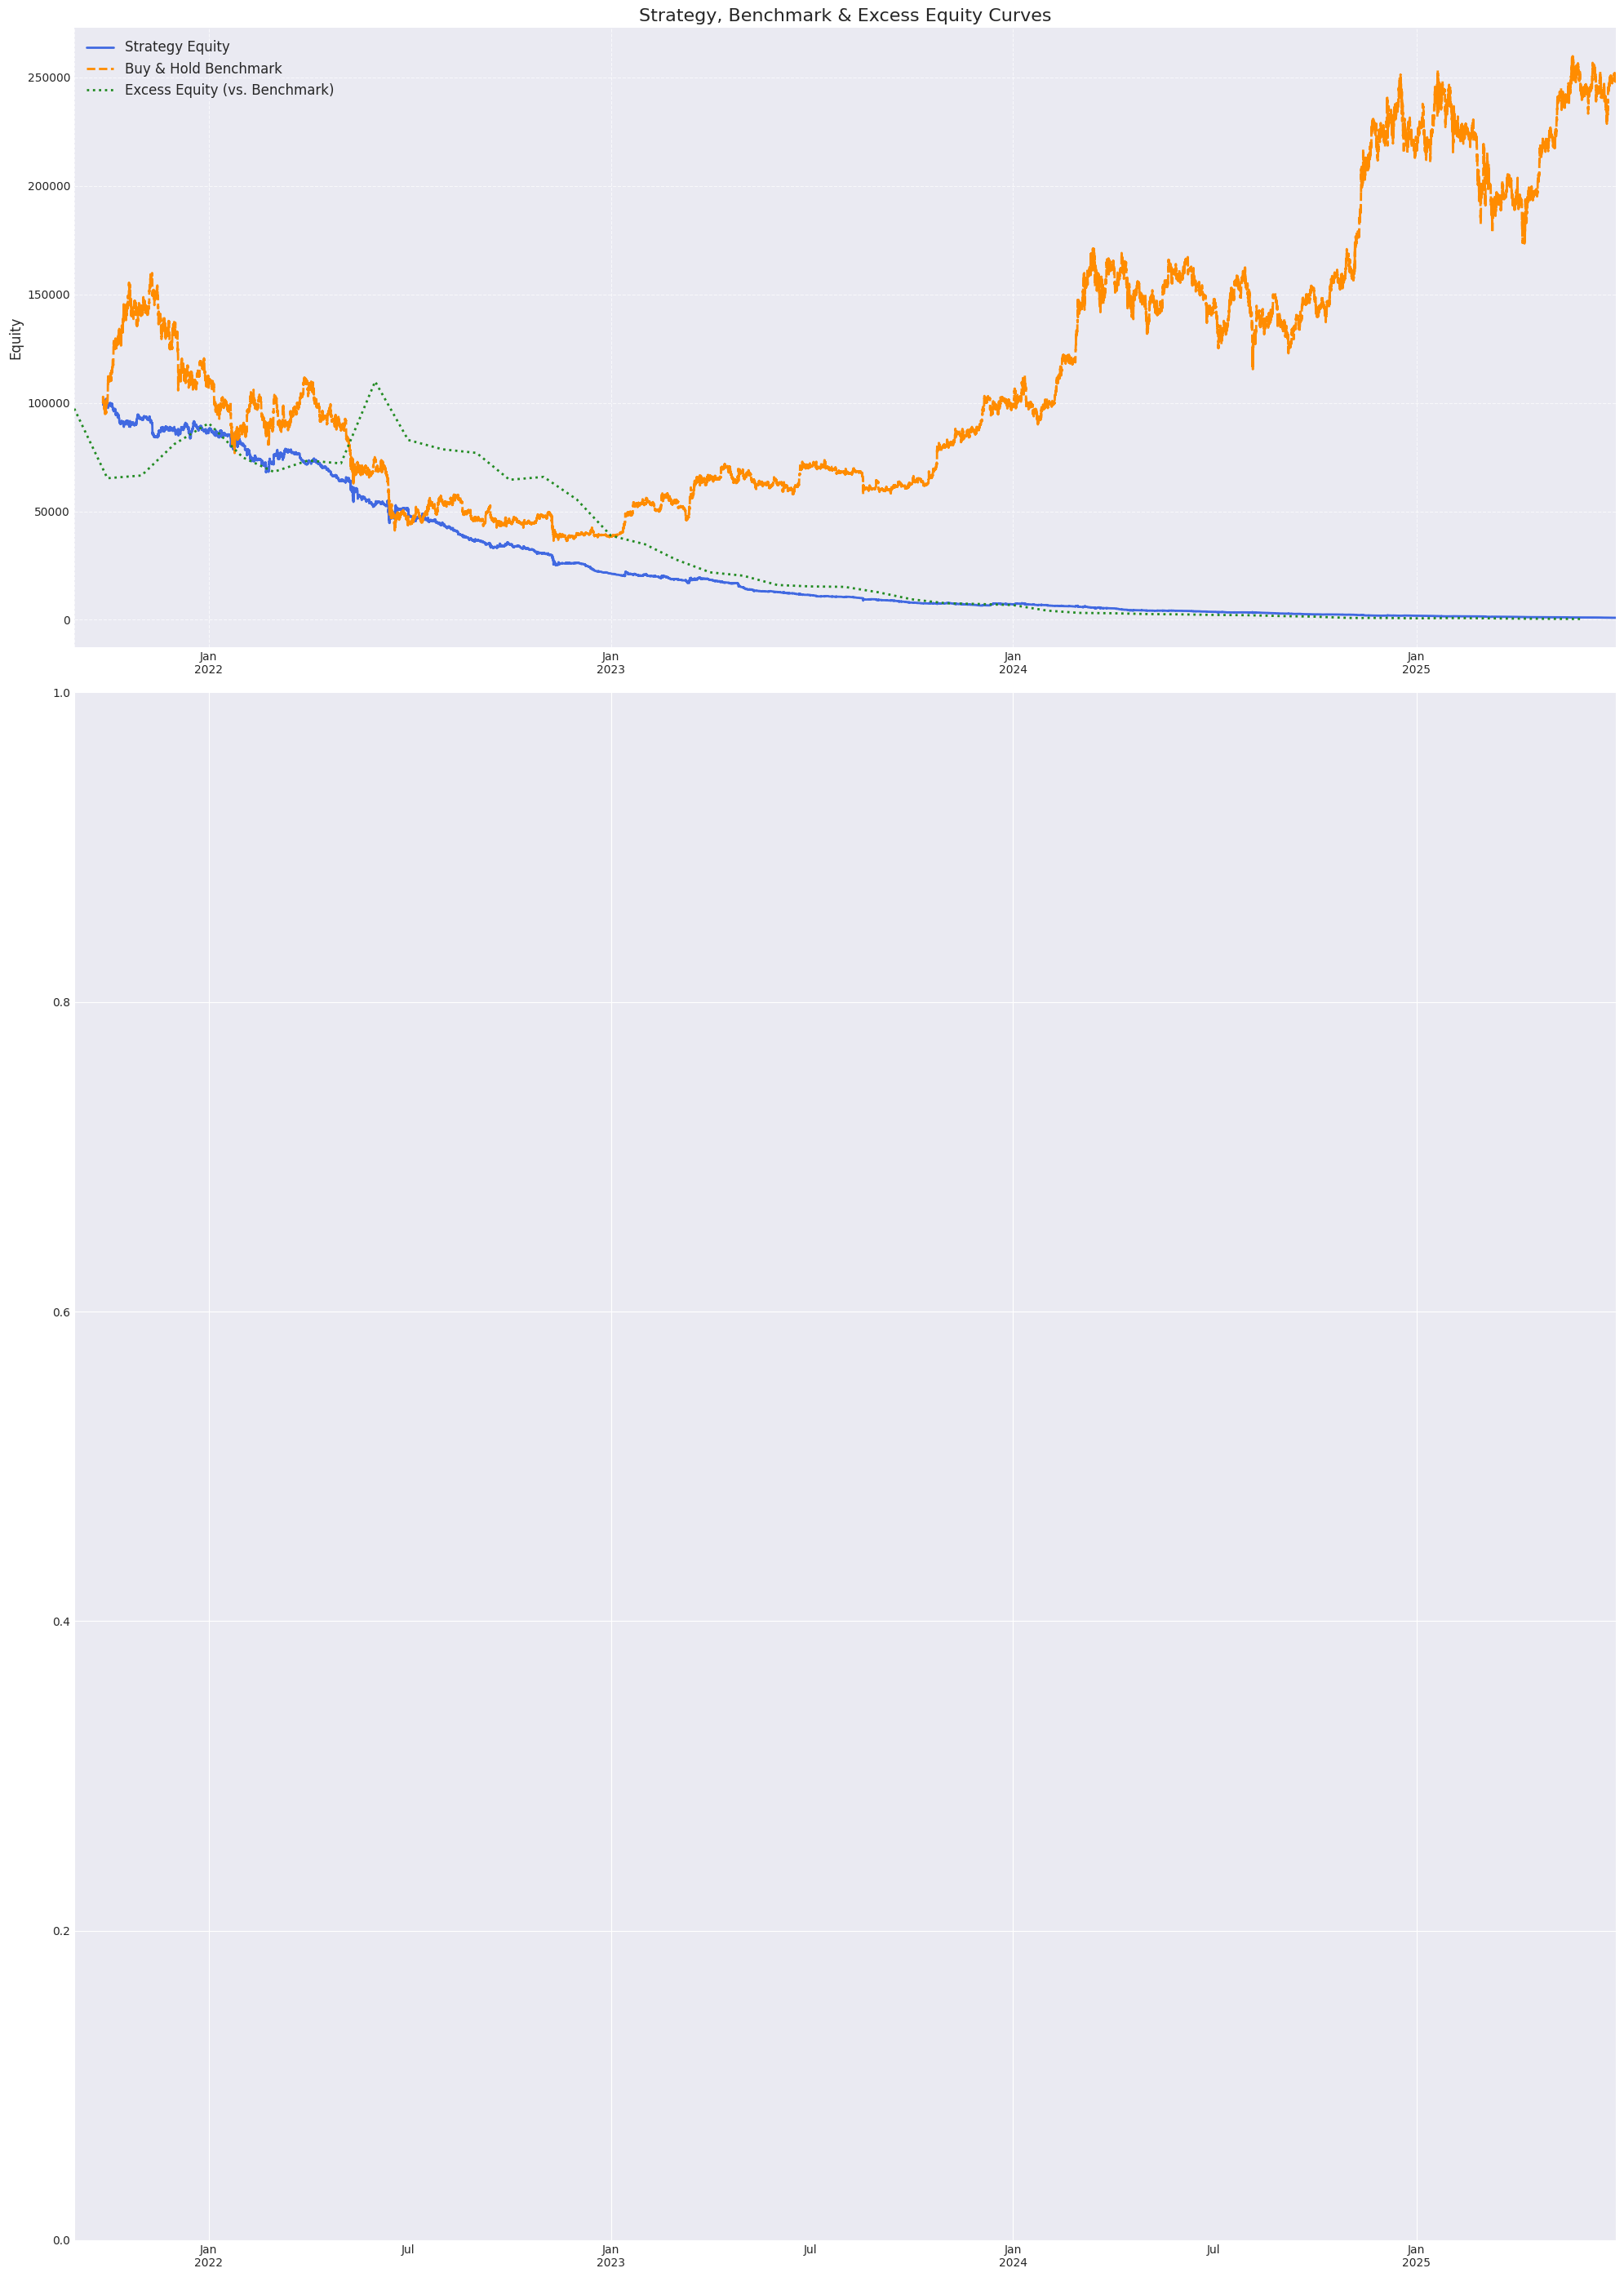

2025-07-23 11:59:46,472 - INFO - 🎊🎊🎊策略评估完成🎊🎊🎊



                         极端因子值统计分析                         
在回测期间未发现明显超出 $\pm3$ 标准差的极端因子值。这表明因子数据在标准化后相对稳定。                             



In [ ]:
if __name__ == '__main__':
    # --- 参数配置 ---
    # 文件路径 (使用带教老师提供的数据)
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    
    # 回测参数 (与原始设定保持一致)
    COMMISSION_RATE = 0.0002     # 交易手续费
    INITIAL_CAPITAL = 100000     # 初始资金

    # !!关键改动!!: 调整阈值以适配已有的 1, 0, -1 信号
    # 当信号是1时, 1 > 0.5 -> position=1 (多)
    # 当信号是-1时, -1 < -0.5 -> position=-1 (空)
    # 当信号是0时, default -> position=0 (平)
    LONG_THRESHOLD = 0.5
    SHORT_THRESHOLD = -0.5

    # 模型评估标准 (与你的原始设定保持一致)
    EVALUATION_CRITERIA = {
        'sharpe_ratio': 2.0,
        'calmar_ratio': 5.0,
        'expectancy': 0.25,
        'max_drawdown': 0.20, # 20%
        'weekly_frequency': 5
    }

    # --- 步骤 1: 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    try:
        backtest_data = pd.read_pickle(FILE_PATH)
        logging.info("数据加载成功。")
        logging.info(f"数据形状: {backtest_data.shape}")
        logging.info(f"数据列名: {backtest_data.columns.tolist()}")
    except FileNotFoundError:
        logging.error(f"错误: 文件未找到 at {FILE_PATH}. 请确认路径是否正确。")
        exit()

    # --- 步骤 2: 执行回测 ---
    # 直接使用加载的数据进行回测
    backtest_results = run_vectorized_backtest(
        prices=backtest_data['close'],
        signals=backtest_data['signal'], # 直接使用数据中的signal列
        initial_capital=INITIAL_CAPITAL,
        commission_rate=COMMISSION_RATE,
        long_threshold=LONG_THRESHOLD,
        short_threshold=SHORT_THRESHOLD
    )
    
    # --- 步骤 3: 性能评估 ---
    # `factor_data` 传入 None，因为本次测试不涉及因子分析
    evaluate_performance(
        backtest_results=backtest_results,
        evaluation_criteria=EVALUATION_CRITERIA,
        initial_capital=INITIAL_CAPITAL,
        factor_data=None 
    )